### Import modules and packages. define functions

In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
import pims
from scipy import stats

%matplotlib inline

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y

def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r

plt.rcParams.update({'font.size': 22})

### Specify experiment directory, condtions and image details
#### Makes dictionary for Protein2r storage of results

In [17]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/' #master folder

In [18]:


Protein1_channel_no=1 
Protein2_channel_no=2


results = {"filename":[],
           "Slice_id":[],
           "exp name":[],
           "Protein1 colour - spots mask":[],
           "Protein2 colour - spots mask":[],
           "exp condition":[],
           "Protein1 colour - Raw mean intensity":[],
           "Protein2 colour - Raw mean intensity":[],
           "Mean correlation coefficient Protein1/Protein2":[],
           "Protein1 colour - Mean intensity of spots":[], #based on spot segmentation mask
           "Protein2 colour - Mean intensity of spots":[], #based on spot segmentation mask
           "Protein1 colour - Total no. of spots in FOV":[],
           "Protein2 colour - Total no. of spots in FOV":[],
           "Protein1 colour - Mean spot area [nm]":[],
           "Protein2 colour - Mean spot area [nm]":[],
           "Mean colour bias of a pixel (Protein1=-1<x<1=Protein2)":[],
           "Protein1 colour - Mean intensity, masked by Protein2 spots":[],
           "Protein1 colour - Mean intensity, outside of Protein2 spots":[]}

path = os.path.dirname(expdir)
print(path)
#outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))
        
print(filelist)

/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use
['/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/.DS_Store', '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/20180710_09_HFS.lif', '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/20180710_08_LFS.lif', '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/20180710_18_LFS.lif', '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/20180710_11_HFS.lif', '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/20180710_10_LFS.lif', '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/20180710_13_HFS.lif', '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/20180710_12_LFS.lif

In [19]:
def get_bytes(size, suffix):
    size = int(float(size))
    suffix = suffix.lower()

    if suffix == 'kb' or suffix == 'kib':
        return size << 10
    elif suffix == 'mb' or suffix == 'mib':
        return size << 20
    elif suffix == 'gb' or suffix == 'gib':
        return size << 30

    return False

In [20]:
get_bytes(5,'mb')

5242880

In [21]:
for i in range(0,len(filelist)):
    if "_use" in str(filelist[i]):
        if filelist[i].endswith(".tif"):
            if os.stat(filelist[i]).st_size<5242880:
                print(filelist[i])

/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/No_drugs/20180710_07_hfs  - series002_series_01.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/No_drugs/20180710_07_hfs  - series004_series_02.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/No_drugs/20180710_07_hfs  - series006_series_03.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/No_drugs/20180710_07_hfs  - series008_series_04.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/No_drugs/20180710_07_hfs  - series010_series_05.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/No_drugs/20180710_07_hfs  - series012_series_06.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/No_drugs/20180710_07_hfs  - series014_series

/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/CNQX_AP5/20180710_09_hfs  - series003_series_02.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/CNQX_AP5/20180710_09_hfs  - series005_series_03.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/CNQX_AP5/20180710_09_hfs  - series007_series_04.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/CNQX_AP5/20180710_09_hfs  - series009_series_05.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/CNQX_AP5/20180710_09_hfs  - series011_series_06.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/CNQX_AP5/20180710_09_hfs  - series013_series_07.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/CNQX_AP5/20180710_09_hfs  - series015_series

/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/GM6001/20180710_14_lfs  - series014_series_07.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/GM6001/20180710_14_lfs  - series016_series_08.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/GM6001/20180710_14_lfs  - series018_series_09.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/GM6001/20180710_14_lfs  - series020_series_10.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/GM6001/20180710_15_hfs _series_1.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/GM6001/20180710_15_hfs  - series002_series_01.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/GM6001/20180710_15_hfs  - series004_series_02.tif
/Volumes/ukps-all$/

In [26]:
#run this to create pools HFS, LFS, Untreated
for i in range(0,len(filelist)):
    if "_use" in str(filelist[i]): 
        if filelist[i].endswith(".tif"):
            if os.stat(filelist[i]).st_size<5242880:
                print(filelist[i])
                if ("hfs" in str(filelist[i]))==True:
                    print('HFS')
                    results["exp name"].append(filelist[i].split('/')[-2])
                    results["filename"].append(filelist[i])
                    results["exp condition"].append('HFS')
                    head, sep, tail = filelist[i].partition('_60x_')
                    head2, sep2, tail2 = head.partition('2018')
                    results["Slice_id"].append(tail2)

                elif ("lfs" in str(filelist[i]))==True:
                    print('LFS')
                    results["exp name"].append(filelist[i].split('/')[-2])
                    results["filename"].append(filelist[i])
                    results["exp condition"].append('LFS')
                    head, sep, tail = filelist[i].partition('_60x_')
                    head2, sep2, tail2 = head.partition('2018')
                    results["Slice_id"].append(tail2)

                elif ("reat" in str(filelist[i]))==True:
                    print('Untrd')
                    results["exp name"].append(filelist[i].split('/')[-2])
                    results["filename"].append(filelist[i])
                    results["exp condition"].append('Untreated')
                    head, sep, tail = filelist[i].partition('_60x_')
                    head2, sep2, tail2 = head.partition('2018')
                    results["Slice_id"].append(tail2)

/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/No_drugs/20180710_07_hfs  - series002_series_01.tif
HFS
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/No_drugs/20180710_07_hfs  - series004_series_02.tif
HFS
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/No_drugs/20180710_07_hfs  - series006_series_03.tif
HFS
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/No_drugs/20180710_07_hfs  - series008_series_04.tif
HFS
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/No_drugs/20180710_07_hfs  - series010_series_05.tif
HFS
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/No_drugs/20180710_07_hfs  - series012_series_06.tif
HFS
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/No_drugs/20180710_07

/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/No_drugs/20180710_08_lfs  - series014_series_07 _series_1.tif
LFS
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/No_drugs/20180710_08_lfs  - series016_series_08 _series_1.tif
LFS
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/No_drugs/20180710_08_lfs  - series018_series_09 _series_1.tif
LFS
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/No_drugs/20180710_08_lfs  - series020_series_10 _series_1.tif
LFS
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/CNQX_AP5/20180710_09_hfs  - series001_series_01.tif
HFS
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/CNQX_AP5/20180710_09_hfs  - series003_series_02.tif
HFS
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710

/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/GM6001/20180710_15_hfs  - series012_series_06.tif
HFS
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/GM6001/20180710_15_hfs  - series014_series_07.tif
HFS
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/GM6001/20180710_15_hfs  - series016_series_08.tif
HFS
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/GM6001/20180710_15_hfs  - series018_series_09.tif
HFS
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/GM6001/20180710_15_hfs  - series020_series_10.tif
HFS
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/GM6001/20180710_09_hfs _series_1.tif
HFS
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/GM6001/20180710_16_lfs  - series002_series_01

### Find the spots: Segmentation masked made by adaptive thresholding followed by binary morphology
#### Play with sigma gauss and i (struct shape) to optimize first

In [27]:
results["filename"]

['/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/No_drugs/20180710_07_hfs  - series002_series_01.tif',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/No_drugs/20180710_07_hfs  - series004_series_02.tif',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/No_drugs/20180710_07_hfs  - series006_series_03.tif',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/No_drugs/20180710_07_hfs  - series008_series_04.tif',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/No_drugs/20180710_07_hfs  - series010_series_05.tif',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/No_drugs/20180710_07_hfs  - series012_series_06.tif',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/No_drugs/20180710_

/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180710_LTP_nanobodies_use/No_drugs/20180710_07_hfs  - series022_series_11.tif


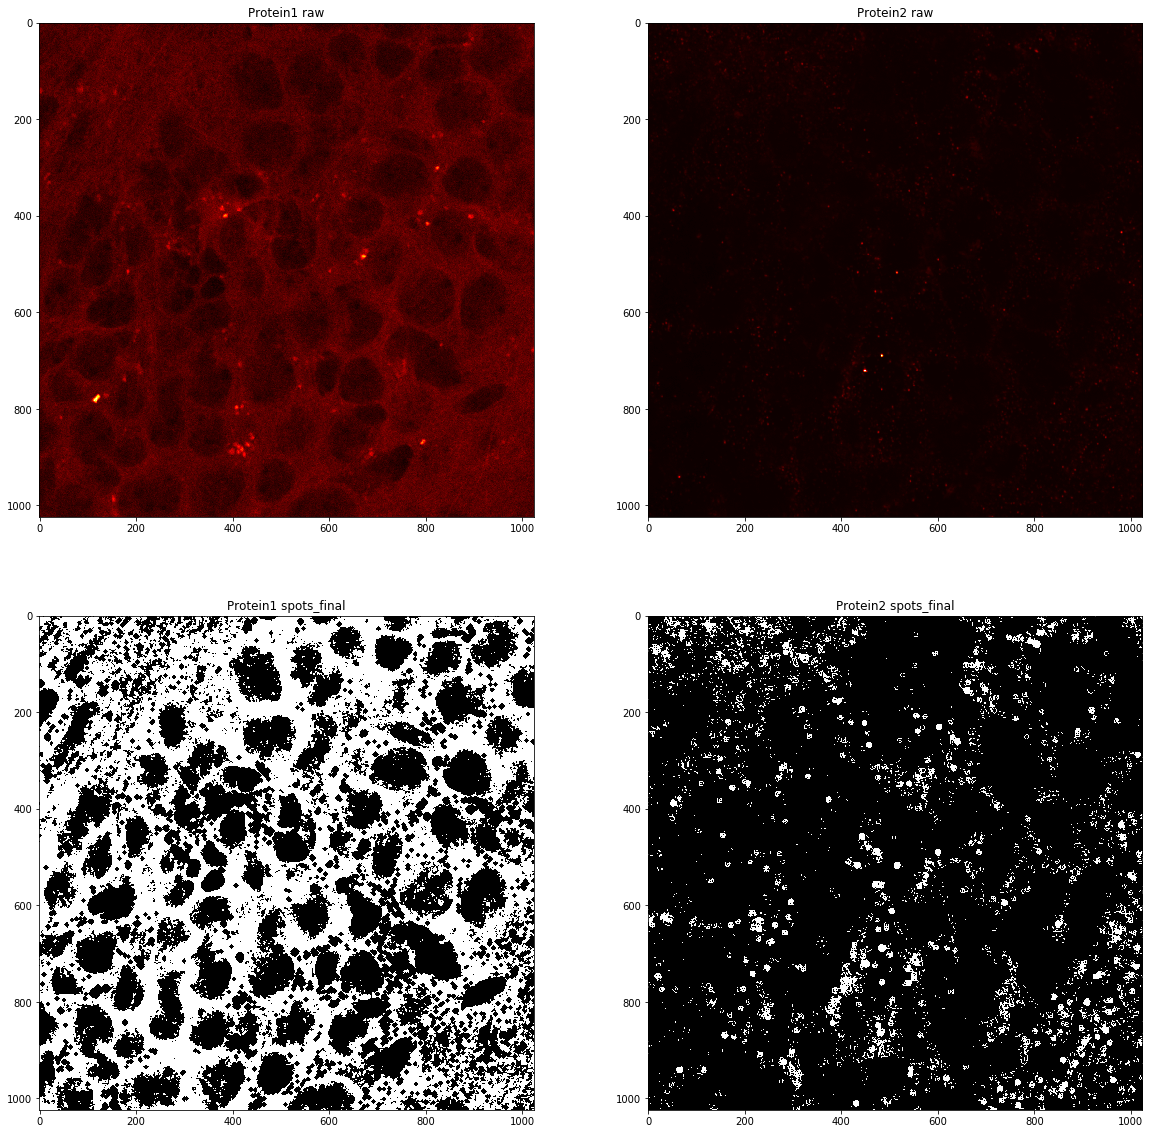

In [28]:
path=results['filename'][10]
print(path)
im = pims.open(path)
Protein1_image=im[Protein1_channel_no-1]
Protein2_image=im[Protein2_channel_no-1]

sigmagauss_Protein1=1 #Smoothing of Protein1 image
sigmagauss_Protein2=0.5 #Smoothing of Protein2 image

Protein1_smooth = ndi.filters.gaussian_filter(Protein1_image,sigmagauss_Protein1)
Protein2_smooth = ndi.filters.gaussian_filter(Protein2_image,sigmagauss_Protein2)

#adaptive thresholding - bg found by mean filter with SE
i_Protein1=151 #for SE of Protein1 image
i_Protein2=11 #for SE of Protein2 image

struct_Protein1 = (np.mgrid[:i_Protein1,:i_Protein1][0] - np.floor(i_Protein1/2))**2 + (np.mgrid[:i_Protein1,:i_Protein1][1] - np.floor(i_Protein1/2))**2 <= np.floor(i_Protein1/2)**2
struct_Protein2 = (np.mgrid[:i_Protein2,:i_Protein2][0] - np.floor(i_Protein2/2))**2 + (np.mgrid[:i_Protein2,:i_Protein2][1] - np.floor(i_Protein2/2))**2 <= np.floor(i_Protein2/2)**2
bg_Protein1 = rank.mean(Protein1_smooth, selem=struct_Protein1)
bg_Protein2 = rank.mean(Protein2_smooth, selem=struct_Protein2)
Protein1_denoised = Protein1_smooth >= bg_Protein1
Protein2_denoised = Protein2_smooth >= bg_Protein2

Protein1_not_toobright=np.logical_not(ndi.morphology.binary_dilation(Protein1_image>np.percentile(Protein1_image,99),iterations=5))
Protein2_not_toobright=np.logical_not(ndi.morphology.binary_dilation(Protein2_image>np.percentile(Protein2_image,99.5)))

#final spots
Protein1_spots=Protein1_not_toobright & Protein1_denoised
Protein2_spots= np.logical_not(Protein2_denoised & Protein2_not_toobright)
            
fig=plt.figure(figsize=(20,20))
fig.add_subplot(2,2,1)
plt.imshow(Protein1_image,interpolation='none',cmap='hot')
plt.title('Protein1 raw')
ax=plt.gca()
ax.grid(color='none')
fig.add_subplot(2,2,2)
plt.imshow(Protein2_image,interpolation='none',cmap='hot')
plt.title('Protein2 raw')
ax=plt.gca()
ax.grid(color='none')
fig.add_subplot(2,2,3)
plt.imshow(Protein1_spots,cmap='gray')
plt.title('Protein1 spots_final')
ax=plt.gca()
ax.grid(color='none')
fig.add_subplot(2,2,4)
plt.imshow(Protein2_spots,cmap='gray')
plt.title('Protein2 spots_final')
ax=plt.gca()
ax.grid(color='none')

In [38]:
results["filename"][0]

IndexError: list index out of range

#### After optimizing, run below to make segmentation masks for all images

In [29]:
print('Total number of images: ' + str(len(results['filename'])))

for i in range(0,len(results["filename"])): 
    print('Calculating image ' + str(i) + 'of ' + str(len(results['filename'])))
    path=results['filename'][i]
    im = pims.open(path)
    Protein1_image=im[Protein1_channel_no-1]
    Protein2_image=im[Protein2_channel_no-1]


    Protein1_smooth = ndi.filters.gaussian_filter(Protein1_image,sigmagauss_Protein1)
    Protein2_smooth = ndi.filters.gaussian_filter(Protein2_image,sigmagauss_Protein2)

    #adaptive thresholding - bg found by mean filter with SE
    i_Protein1=151 #for SE of Protein1 image
    i_Protein2=11 #for SE of Protein2 image

    struct_Protein1 = (np.mgrid[:i_Protein1,:i_Protein1][0] - np.floor(i_Protein1/2))**2 + (np.mgrid[:i_Protein1,:i_Protein1][1] - np.floor(i_Protein1/2))**2 <= np.floor(i_Protein1/2)**2
    struct_Protein2 = (np.mgrid[:i_Protein2,:i_Protein2][0] - np.floor(i_Protein2/2))**2 + (np.mgrid[:i_Protein2,:i_Protein2][1] - np.floor(i_Protein2/2))**2 <= np.floor(i_Protein2/2)**2
    bg_Protein1 = rank.mean(Protein1_smooth, selem=struct_Protein1)
    bg_Protein2 = rank.mean(Protein2_smooth, selem=struct_Protein2)
    Protein1_denoised = Protein1_smooth >= bg_Protein1
    Protein2_denoised = Protein2_smooth >= bg_Protein2

    Protein1_not_toobright=np.logical_not(ndi.morphology.binary_dilation(Protein1_image>np.percentile(Protein1_image,99),iterations=5))
    Protein2_not_toobright=np.logical_not(ndi.morphology.binary_dilation(Protein2_image>np.percentile(Protein2_image,99.5)))

    #final spots
    Protein1_spots=Protein1_not_toobright & Protein1_denoised
    Protein2_spots= np.logical_not(Protein2_denoised & Protein2_not_toobright)

    results["Protein1 colour - spots mask"].append(Protein1_spots)
    results["Protein2 colour - spots mask"].append(Protein2_spots)

Total number of images: 166
Calculating image 0of 166
Calculating image 1of 166
Calculating image 2of 166
Calculating image 3of 166
Calculating image 4of 166
Calculating image 5of 166
Calculating image 6of 166
Calculating image 7of 166
Calculating image 8of 166
Calculating image 9of 166
Calculating image 10of 166
Calculating image 11of 166
Calculating image 12of 166
Calculating image 13of 166
Calculating image 14of 166
Calculating image 15of 166
Calculating image 16of 166
Calculating image 17of 166
Calculating image 18of 166
Calculating image 19of 166
Calculating image 20of 166
Calculating image 21of 166
Calculating image 22of 166
Calculating image 23of 166
Calculating image 24of 166
Calculating image 25of 166
Calculating image 26of 166
Calculating image 27of 166
Calculating image 28of 166
Calculating image 29of 166
Calculating image 30of 166
Calculating image 31of 166
Calculating image 32of 166
Calculating image 33of 166
Calculating image 34of 166
Calculating image 35of 166
Calculatin

IndexError: index out of range

#### Verify the segmentation (look at a random subset of raw images and their masks)

/anaconda3/lib/python3.6/site-packages/tifffile/tifffile.py:2894: UserWarning: invalid page offset (2117224)
  warnings.warn('invalid page offset (%i)' % offset)


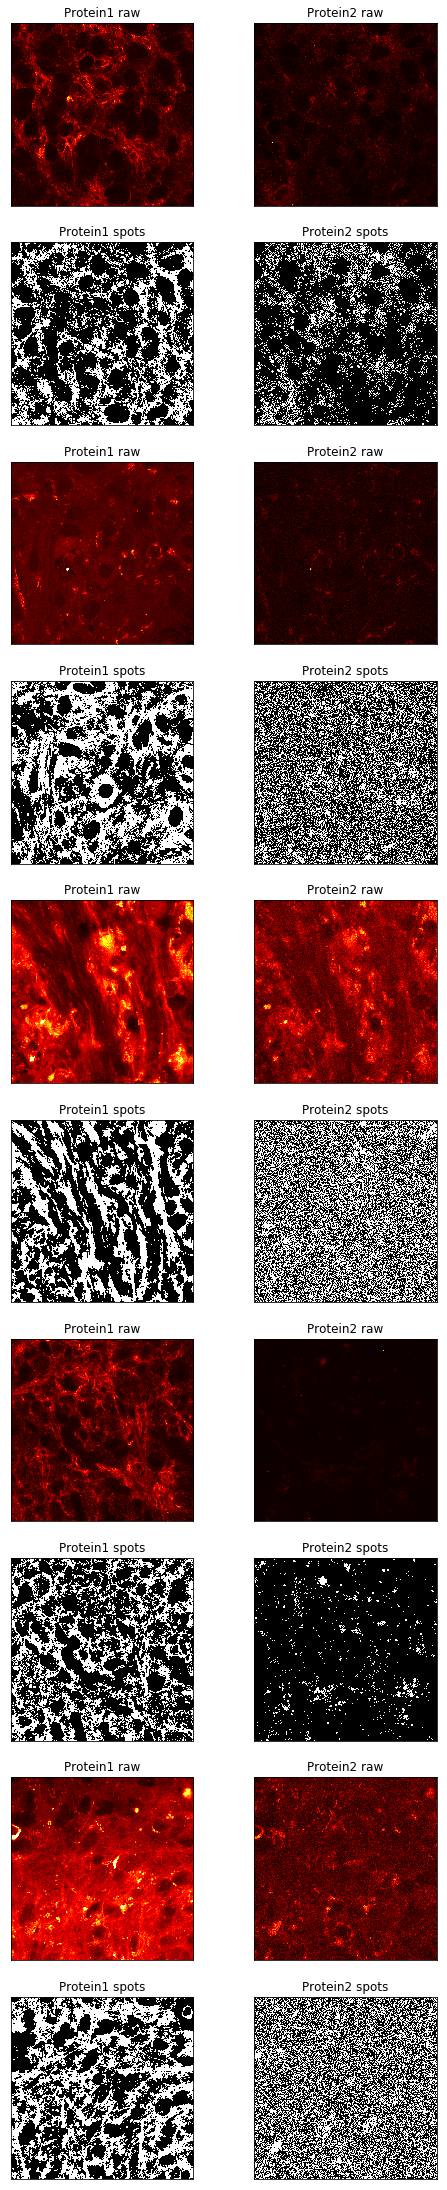

In [76]:
fig=plt.figure(figsize=(8,80))
figno=1
for im in range(0,5):
    randindex=np.random.randint(1,len(results["filename"]))
    path=results["filename"][randindex]
    image = pims.open(path)
    Protein1_image=image[Protein1_channel_no-1]
    Protein2_image=image[Protein2_channel_no-1]
    Protein1_spots=results["Protein1 colour - spots mask"][randindex]
    Protein2_spots=results["Protein2 colour - spots mask"][randindex]
    
    fig.add_subplot(20,2,figno)
    plt.imshow(Protein1_image,interpolation='none',cmap='hot')
    plt.title('Protein1 raw')
    plt.ylabel(path)
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.add_subplot(20,2,figno+1)
    plt.imshow(Protein2_image,interpolation='none',cmap='hot')
    plt.title('Protein2 raw')
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.add_subplot(20,2,figno+2)
    plt.imshow(Protein1_spots,interpolation='none',cmap='gray')
    plt.title('Protein1 spots')
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.add_subplot(20,2,figno+3)
    plt.imshow(Protein2_spots,interpolation='none',cmap='gray')
    plt.title('Protein2 spots')

    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    figno=figno+4

### Batch analyse images, after creating the segmentation masks

In [ ]:
print('Total number of images: ' + str(len(results['filename'])))
for i in range(295,len(results["filename"])):    
    print('Calculating image ' + str(i) + 'of ' + str(len(results['filename'])))
    path=results['filename'][i]
    im = pims.open(path)
    Protein1_image=im[Protein1_channel_no-1]
    Protein2_image=im[Protein2_channel_no-1]
    #read spots masks
    Protein1_spots=results["Protein1 colour - spots mask"][i]
    Protein2_spots=results["Protein2 colour - spots mask"][i]
    #label the spots
    spots_Protein1_labels,_ = ndi.label(Protein1_spots)
    spots_Protein2_labels,_ = ndi.label(Protein2_spots)
    #calcuProtein2 results
    Protein1_spots_intensities=np.zeros((len(np.unique(spots_Protein1_labels)),1))
    Protein1_spots_areas=np.zeros((len(np.unique(spots_Protein1_labels)),1))
    Protein1_spots_intensities_maskedbyProtein2=np.zeros((len(np.unique(spots_Protein2_labels)),1))
    Protein2_spots_intensities=np.zeros((len(np.unique(spots_Protein2_labels)),1))
    Protein2_spots_areas=np.zeros((len(np.unique(spots_Protein2_labels)),1))
    spots_Protein2_minus_Protein1_int=np.zeros((len(np.unique(spots_Protein1_labels)),1))

    for spotno in np.unique(spots_Protein1_labels)[1:]:
        Protein1_spots_mask = spots_Protein1_labels==spotno
        Protein1_spots_intensities[(spotno)]=np.mean(Protein1_image[Protein1_spots_mask])
        Protein1_spots_areas[spotno]=np.sum(Protein1_spots_mask)
        
        #calculation for Protein2 minus Protein1, based on Protein1 spots only
        a=Protein2_image[Protein1_spots_mask]
        b=Protein1_image[Protein1_spots_mask]
        spots_Protein2_minus_Protein1_int[spotno]=np.mean(np.divide([a-b],[a+b]))
        
    for spotnol in np.unique(spots_Protein2_labels)[1:]:
        Protein2_spots_mask= spots_Protein2_labels==spotnol
        Protein2_spots_intensities[spotnol]=np.mean(Protein2_image[Protein2_spots_mask])
        Protein2_spots_areas[spotnol]=np.sum(Protein2_spots_mask)
        Protein1_spots_intensities_maskedbyProtein2=np.mean(Protein1_image[Protein2_spots_mask])
        Protein1_spots_intensities_notProtein2=np.mean(Protein1_image[np.invert(Protein2_spots_mask)])

    #the following results are calculated on the raw data

    #results based on spot segmentation    
    results["Protein1 colour - Mean intensity of spots"].append(np.mean(Protein1_spots_intensities))
    results["Protein2 colour - Mean intensity of spots"].append(np.mean(Protein2_spots_intensities))
    results["Protein1 colour - Total no. of spots in FOV"].append(len(Protein1_spots_intensities))
    results["Protein2 colour - Total no. of spots in FOV"].append(len(Protein2_spots_intensities))
    results["Protein1 colour - Mean spot area [nm]"].append(np.mean(Protein1_spots_areas))
    results["Protein2 colour - Mean spot area [nm]"].append(np.mean(Protein2_spots_areas))
    results["Protein1 colour - Mean intensity, masked by Protein2 spots"].append(np.mean(Protein1_spots_intensities_maskedbyProtein2))
    results["Protein1 colour - Mean intensity, outside of Protein2 spots"].append(np.mean(Protein1_spots_intensities_notProtein2))

    #global results
    results["Protein1 colour - Raw mean intensity"].append(np.mean(Protein1_image))
    results["Protein2 colour - Raw mean intensity"].append(np.mean(Protein2_image))
    results["Mean correlation coefficient Protein1/Protein2"].append(corr2(Protein1_image,Protein2_image))
    results["Mean colour bias of a pixel (Protein1=-1<x<1=Protein2)"].append(np.mean(spots_Protein2_minus_Protein1_int))

Total number of images: 528
Calculating image 295of 528


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


Calculating image 296of 528


/anaconda3/lib/python3.6/site-packages/tifffile/tifffile.py:2894: UserWarning: invalid page offset (2117224)
  warnings.warn('invalid page offset (%i)' % offset)


Calculating image 297of 528
Calculating image 298of 528
Calculating image 299of 528
Calculating image 300of 528
Calculating image 301of 528
Calculating image 302of 528
Calculating image 303of 528
Calculating image 304of 528
Calculating image 305of 528
Calculating image 306of 528
Calculating image 307of 528
Calculating image 308of 528
Calculating image 309of 528
Calculating image 310of 528
Calculating image 311of 528
Calculating image 312of 528
Calculating image 313of 528
Calculating image 314of 528
Calculating image 315of 528
Calculating image 316of 528
Calculating image 317of 528
Calculating image 318of 528
Calculating image 319of 528
Calculating image 320of 528
Calculating image 321of 528
Calculating image 322of 528
Calculating image 323of 528
Calculating image 324of 528
Calculating image 325of 528
Calculating image 326of 528
Calculating image 327of 528
Calculating image 328of 528
Calculating image 329of 528
Calculating image 330of 528
Calculating image 331of 528
Calculating image 33

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


Calculating image 338of 528
Calculating image 339of 528
Calculating image 340of 528
Calculating image 341of 528
Calculating image 342of 528
Calculating image 343of 528
Calculating image 344of 528
Calculating image 345of 528
Calculating image 346of 528
Calculating image 347of 528
Calculating image 348of 528
Calculating image 349of 528
Calculating image 350of 528
Calculating image 351of 528
Calculating image 352of 528
Calculating image 353of 528
Calculating image 354of 528
Calculating image 355of 528
Calculating image 356of 528
Calculating image 357of 528
Calculating image 358of 528
Calculating image 359of 528
Calculating image 360of 528
Calculating image 361of 528
Calculating image 362of 528
Calculating image 363of 528
Calculating image 364of 528
Calculating image 365of 528
Calculating image 366of 528
Calculating image 367of 528
Calculating image 368of 528
Calculating image 369of 528
Calculating image 370of 528
Calculating image 371of 528
Calculating image 372of 528
Calculating image 37

In [83]:
keys=['Protein1 colour - spots mask', 'Protein2 colour - spots mask', 'exp condition', 'Protein1 colour - Raw mean intensity', 'Protein2 colour - Raw mean intensity', 'Mean correlation coefficient Protein1/Protein2', 'Protein1 colour - Mean intensity of spots', 'Protein2 colour - Mean intensity of spots', 'Protein1 colour - Total no. of spots in FOV', 'Protein2 colour - Total no. of spots in FOV', 'Protein1 colour - Mean spot area [nm]', 'Protein2 colour - Mean spot area [nm]', 'Mean colour bias of a pixel (Protein1=-1<x<1=Protein2)', 'Protein1 colour - Mean intensity, masked by Protein2 spots', 'Protein1 colour - Mean intensity, outside of Protein2 spots']


for key in keys:
    results[key].append(results[key][293])

In [84]:
for key in results.keys():
    print(len(results[key]))

528
528
528
529
529
529
295
295
295
295
295
295
295
295
295
295
295
295


In [70]:
df["expname2"]=""

In [71]:
for i in range(0,len(df)):
    df["expname2"].iloc[i]=df.iloc[i]["filename"].split('/')[-4]



/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [85]:
df=df[df["expname2"] != "20180131and0201_LTPStim_TNR_GluR1_notdoneimaging"]

In [98]:
df[df["expname2"]=="20180131_0201"]

,Drug,Mean colour bias of a pixel (Protein1=-1<x<1=Protein2),Mean correlation coefficient Protein1/Protein2,Protein1 colour - Mean intensity of spots,Protein1 colour - Mean intensity of spots norm2max,"Protein1 colour - Mean intensity, masked by Protein2 spots","Protein1 colour - Mean intensity, outside of Protein2 spots",Protein1 colour - Mean spot area [nm],Protein1 colour - Raw mean intensity,Protein1 colour - Total no. of spots in FOV,...,Protein2 colour - Raw mean intensity,Protein2 colour - Total no. of spots in FOV,Protein2 colour - spots mask,Slice_id,Unnamed: 0,exp condition,exp name,expname2,filename,label
0,No Drugs,inf,0.0628346,23.1213,0.288748,1,17.4111,186.222,17.411,2148,...,18.7782,2759,[[False False False ... False False False]\n [...,0131and0201_LTPStim_TNR_GluR1_notdoneimaging/2...,0,HFS,20180131_0201,20180131_0201,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/O...,fabs
1,No Drugs,inf,0.0955125,33.2104,0.414745,6,24.0828,199.216,24.0828,1987,...,23.0088,2818,[[False False False ... True True True]\n [...,0131and0201_LTPStim_TNR_GluR1_notdoneimaging/2...,1,HFS,20180131_0201,20180131_0201,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/O...,fabs
2,No Drugs,inf,0.125325,14.4772,0.180796,5.5,12.4821,118.024,12.4821,3064,...,19.5992,2670,[[ True True True ... False False False]\n [...,0131and0201_LTPStim_TNR_GluR1_notdoneimaging/2...,2,HFS,20180131_0201,20180131_0201,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/O...,fabs
3,No Drugs,3.82508,0.070427,28.8823,0.360693,39.5,21.6732,179.129,21.6733,2328,...,18.9067,2922,[[ True False False ... False False False]\n [...,0131and0201_LTPStim_TNR_GluR1_notdoneimaging/2...,3,HFS,20180131_0201,20180131_0201,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/O...,fabs
4,No Drugs,inf,0.0342123,24.125,0.301282,19.5,18.0356,158.447,18.0356,2539,...,18.9792,2774,[[ True True True ... True True True]\n [...,0131and0201_LTPStim_TNR_GluR1_notdoneimaging/2...,4,HFS,20180131_0201,20180131_0201,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/O...,fabs
5,No Drugs,inf,0.0227647,25.2158,0.314904,40.6667,19.7672,233.309,19.7672,1753,...,21.4997,2375,[[False False False ... True True True]\n [...,0131and0201_LTPStim_TNR_GluR1_notdoneimaging/2...,5,HFS,20180131_0201,20180131_0201,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/O...,fabs
6,No Drugs,inf,0.00564749,33.1374,0.413833,16.5,24.482,222.342,24.482,1892,...,19.3632,2972,[[False False False ... False False False]\n [...,0131and0201_LTPStim_TNR_GluR1_notdoneimaging/2...,6,HFS,20180131_0201,20180131_0201,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/O...,fabs
7,No Drugs,inf,0.0358338,17.4045,0.217354,3.25,14.5092,140.339,14.5091,2736,...,15.7923,2203,[[ True True True ... True True False]\n [...,0131and0201_LTPStim_TNR_GluR1_notdoneimaging/2...,7,HFS,20180131_0201,20180131_0201,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/O...,fabs
8,No Drugs,inf,0.161787,22.2285,0.277598,28.6667,18.0418,158.841,18.0418,2502,...,18.0588,2904,[[False False True ... True True True]\n [...,0131and0201_LTPStim_TNR_GluR1_notdoneimaging/2...,8,HFS,20180131_0201,20180131_0201,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/O...,fabs
9,No Drugs,inf,0.072757,18.601,0.232297,17,15.5562,168.531,15.5562,2367,...,19.1096,2487,[[False False False ... True True True]\n [...,0131and0201_LTPStim_TNR_GluR1_notdoneimaging/2...,9,HFS,20180131_0201,20180131_0201,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/O...,fabs


In [153]:
df['Protein1 colour - Mean intensity of spots norm2max'] = df["Protein1 colour - Mean intensity of spots"]/df.groupby(["expname2"])["Protein1 colour - Mean intensity of spots"].transform(np.max)
df['Protein2 colour - Mean intensity of spots norm2max'] = df["Protein2 colour - Mean intensity of spots"]/df.groupby(["expname2"])["Protein2 colour - Mean intensity of spots"].transform(np.max)



In [163]:
df.groupby(["Drug"])["Protein1 colour - Mean intensity of spots norm2max"].max()

Drug
AP5              0.947285
CNQXandAP5       0.689548
Cycloheximide    1.000000
GM6001           0.866447
No Drugs         1.000000
Name: Protein1 colour - Mean intensity of spots norm2max, dtype: float64

### Make a clean figure of an experimental condition, with merged image and scalebar

In [ ]:
experimental_condition_to_displax='LFS' #'1 day' or '1 day + bic'

medfiltarray=[3,3] #play with med filter size

fig=plt.figure(figsize=(10,250))
no_of_ims_in_condition = sum( x == experimental_condition_to_display for x in results["exp condition"] )
print(no_of_ims_in_condition)
counter=1

for i in range(0,len(results["filename"])): 
    if (results["exp condition"][i]==experimental_condition_to_display and counter<15):
        path=results['filename'][i]
        im = pims.open(path)
        Protein1_image=im[Protein1_channel_no-1]
        Protein2_image=im[Protein2_channel_no-1]
       
        #some basic preprocessing: smoothing (noise reduction) with med filter, and contrast adjustment
        Protein1_smoothed=ndi.filters.median_filter(Protein1_image,medfiltarray)
        v_min1, v_max1 = np.percentile(Protein1_smoothed, (0.2, 99.8))
        Protein1_smoothed_adjusted=exposure.rescale_intensity(Protein1_smoothed, in_range=(v_min1, v_max1))
        Protein2_smoothed=ndi.filters.median_filter(Protein2_image,medfiltarray)
        v_min2, v_max2 = np.percentile(Protein2_smoothed, (0.2, 99.8))
        Protein2_smoothed_adjusted=exposure.rescale_intensity(Protein2_smoothed, in_range=(v_min2, v_max2))

        #make Protein1 image red and Protein2 image green
        greencmap = clr.LinearSegmentedColormap.from_list('customred', ['#000000','#06C420'], N=256)
        redcmap=clr.LinearSegmentedColormap.from_list('customred', ['#000000','#FD0120'], N=256)

        normProtein1 = Protein1_smoothed_adjusted.astype(np.float32) # convert to float
        normProtein1 -= normProtein1.min() # ensure the minimal value is 0.0
        normProtein1 /= normProtein1.max() # maximum value in image is now 1.0
        normProtein2 = Protein2_smoothed_adjusted.astype(np.float32) # convert to float
        normProtein2 -= normProtein2.min() # ensure the minimal value is 0.0
        normProtein2 /= normProtein2.max() # maximum value in image is now 1.0

        Protein2_ingreen=greencmap(normProtein2)
        Protein1_inred=redcmap(normProtein1)

        #make composite with a scalebar
        comp=Image.blend(toimage(Protein1_inred),toimage(Protein2_ingreen),0.5)
        micronsperpixel=0.0962
        scalebar = ScaleBar(dx=micronsperpixel,units='um',color='white',length_fraction=0.16,box_color='none') # 1 pixel = 0.2 meter

        fig.add_subplot(no_of_ims_in_condition,3,counter)
        plt.imshow(Protein1_inred,interpolation='none')
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
        plt.gca().set_aspect('equal')
        plt.gca().grid(color='none')

        fig.add_subplot(no_of_ims_in_condition,3,(counter+1))
        plt.imshow(Protein2_ingreen,interpolation='none')
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
        plt.gca().set_aspect('equal')
        plt.gca().grid(color='none')

        fig.add_subplot(no_of_ims_in_condition,3,(counter+2))
        plt.imshow(comp)
        plt.gca().add_artist(scalebar)
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
        plt.gca().set_aspect('equal')
        plt.gca().grid(color='none')

        counter=counter+3

plt.subplots_adjust(wspace=0, hspace=0)

## Plots

In [78]:
df=pd.DataFrame(results)

ValueError: arrays must all be same length

In [ ]:
df=pd.read_csv('')

In [11]:
df["Drug"] = "None"

In [179]:
#df[df[Slice_id]]
df.loc[df['Slice_id'].str.contains('DMSO'), 'Drug'] = 'DMSO'
df.loc[df['Slice_id'].str.contains('No_Drug'), 'Drug'] = 'No Drugs'
df.loc[df['Slice_id'].str.contains('GM6001'), 'Drug'] = 'GM6001'
df.loc[df['Slice_id'].str.contains('CNQX_AP5'), 'Drug'] = 'CNQXandAP5'
df.loc[df['Slice_id'].str.contains('Cycloheximide'), 'Drug'] = 'Cycloheximidine'





In [32]:
df.loc[df['Slice_id'].str.contains('notdone'), 'Drug'] = 'No Drugs'

In [44]:
df.loc

KeyError: -2

### Write to pickle

In [182]:
#output = os.path.abspath(os.path.join(expdir, 'results.csv'))

df.to_csv(expdir+'results/results.csv')

### Read previously stored pickle file

In [89]:
df3=pd.read_csv('/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180131and0201_LTPStim_TNR_GluR1_notdoneimaging/results.csv')

In [90]:
df3.columns

Index(['Unnamed: 0', 'Mean colour bias of a pixel (Protein1=-1<x<1=Protein2)',
       'Mean correlation coefficient Protein1/Protein2',
       'Protein1 colour - Mean intensity of spots',
       'Protein1 colour - Mean intensity, masked by Protein2 spots',
       'Protein1 colour - Mean intensity, outside of Protein2 spots',
       'Protein1 colour - Mean spot area [nm]',
       'Protein1 colour - Raw mean intensity',
       'Protein1 colour - Total no. of spots in FOV',
       'Protein1 colour - spots mask',
       'Protein2 colour - Mean intensity of spots',
       'Protein2 colour - Mean spot area [nm]',
       'Protein2 colour - Raw mean intensity',
       'Protein2 colour - Total no. of spots in FOV',
       'Protein2 colour - spots mask', 'Slice_id', 'exp condition', 'filename',
       'Drug'],
      dtype='object')

In [91]:
df3['label']='fabs'
df3['exp name']='20180131_0201'
df3['expname2']="20180131_0201"
df3['Drug']='No Drugs'

In [37]:
df[df["Drug"]=="None"]

,Drug,Mean colour bias of a pixel (Protein1=-1<x<1=Protein2),Mean correlation coefficient Protein1/Protein2,Protein1 colour - Mean intensity of spots,"Protein1 colour - Mean intensity, masked by Protein2 spots","Protein1 colour - Mean intensity, outside of Protein2 spots",Protein1 colour - Mean spot area [nm],Protein1 colour - Raw mean intensity,Protein1 colour - Total no. of spots in FOV,Protein1 colour - spots mask,...,Protein2 colour - Mean spot area [nm],Protein2 colour - Raw mean intensity,Protein2 colour - Total no. of spots in FOV,Protein2 colour - spots mask,Slice_id,Unnamed: 0,exp condition,exp name,filename,label


In [92]:
df=df.append(df3)

In [108]:
df['MergedDrugs']=df['Drug']
df.loc[df['Drug'].str.contains('DMSO'), 'MergedDrugs'] = 'No Drugs'

### Bar plots of all of the data, no statistics

In [123]:
df3['Protein1 colour - Mean intensity of spots norm2max']

0       0.354036
1        0.29032
2       0.226367
3       0.204621
4       0.262346
5       0.332223
6       0.406377
7         0.3697
8       0.340231
9       0.326887
10      0.357973
11      0.383496
12      0.278985
13       0.28083
14      0.282163
15       0.31824
16      0.270179
17      0.242616
18      0.386247
19      0.308869
20      0.316883
21      0.311719
22      0.239014
23      0.284046
37      0.254476
38      0.308948
39      0.242216
40      0.269594
41      0.284021
42      0.279454
         ...    
133     0.418295
147    0.0994552
148    0.0933836
149     0.204374
150     0.162154
151     0.119654
152     0.204809
153     0.205235
154     0.185076
155     0.199958
156     0.132295
157     0.164512
158     0.147284
159     0.199455
160     0.112058
174     0.338397
175     0.389644
176      0.46935
177     0.356992
178     0.343019
179     0.345692
180     0.540687
181     0.577494
182     0.506259
183     0.396948
184     0.353499
185     0.222311
186     0.5076

In [223]:
df3=df[(df["label"]=="fabs")&(df["exp condition"]!="Untreated")&(df["MergedDrugs"]!="GM6001")]
vars2plot=['Mean colour bias of a pixel (Protein1=-1<x<1=Protein2)',
       'Mean correlation coefficient Protein1/Protein2',
       'Protein1 colour - Mean intensity of spots',
           'Protein1 colour - Mean intensity of spots norm2max',
       'Protein1 colour - Mean intensity, masked by Protein2 spots',
       'Protein1 colour - Mean intensity, outside of Protein2 spots',
       'Protein1 colour - Mean spot area [nm]',
       'Protein1 colour - Raw mean intensity',
       'Protein1 colour - Total no. of spots in FOV',
       
       'Protein2 colour - Mean intensity of spots',
       'Protein2 colour - Mean spot area [nm]',
       'Protein2 colour - Raw mean intensity',
       'Protein2 colour - Total no. of spots in FOV']




In [235]:
df3.columns

Index(['Drug', 'Mean colour bias of a pixel (Protein1=-1<x<1=Protein2)',
       'Mean correlation coefficient Protein1/Protein2',
       'Protein1 colour - Mean intensity of spots',
       'Protein1 colour - Mean intensity of spots norm2max',
       'Protein1 colour - Mean intensity, masked by Protein2 spots',
       'Protein1 colour - Mean intensity, outside of Protein2 spots',
       'Protein1 colour - Mean spot area [nm]',
       'Protein1 colour - Raw mean intensity',
       'Protein1 colour - Total no. of spots in FOV',
       'Protein1 colour - spots mask',
       'Protein2 colour - Mean intensity of spots',
       'Protein2 colour - Mean intensity of spots norm2max',
       'Protein2 colour - Mean spot area [nm]',
       'Protein2 colour - Raw mean intensity',
       'Protein2 colour - Total no. of spots in FOV',
       'Protein2 colour - spots mask', 'Slice_id', 'Unnamed: 0',
       'exp condition', 'exp name', 'expname2', 'filename', 'label',
       'MergedDrugs'],
      dtype

20180316_LTPStim_Cy3laserto20percent_use
number of no drug 0
number of DMSO 0
20180411and0412_LTPStim_Cy3laserto25percent_use
number of no drug 24
number of DMSO 34
20180214and0215_LTPStim_betweenframes_newlaser
number of no drug 102
number of DMSO 0
20180131_0201
number of no drug 189
number of DMSO 0


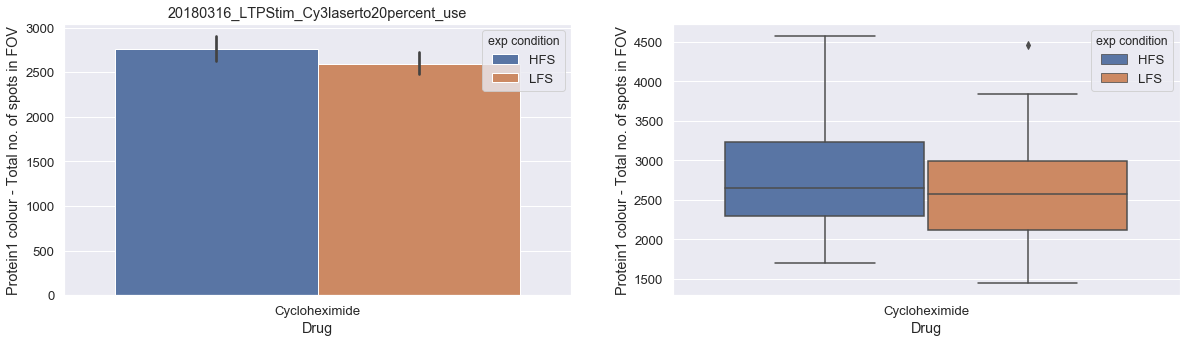

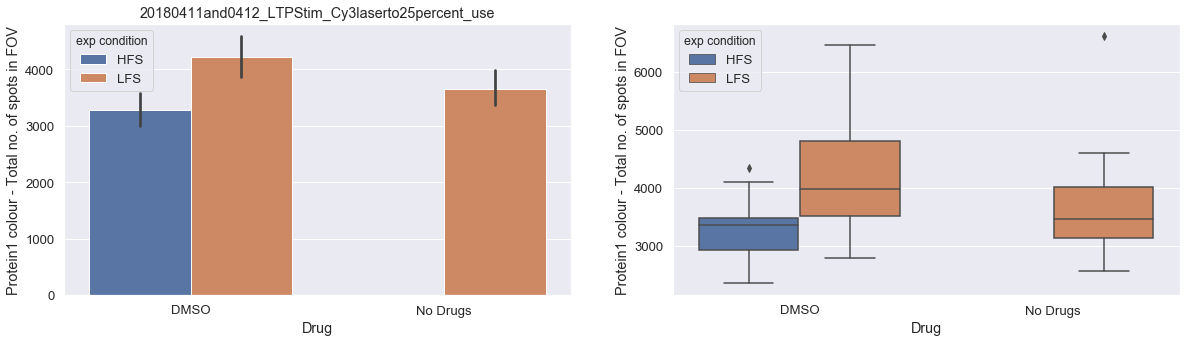

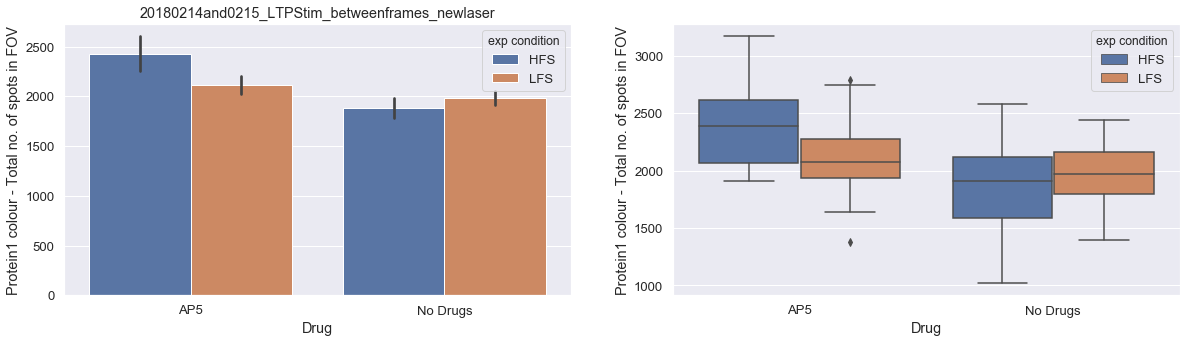

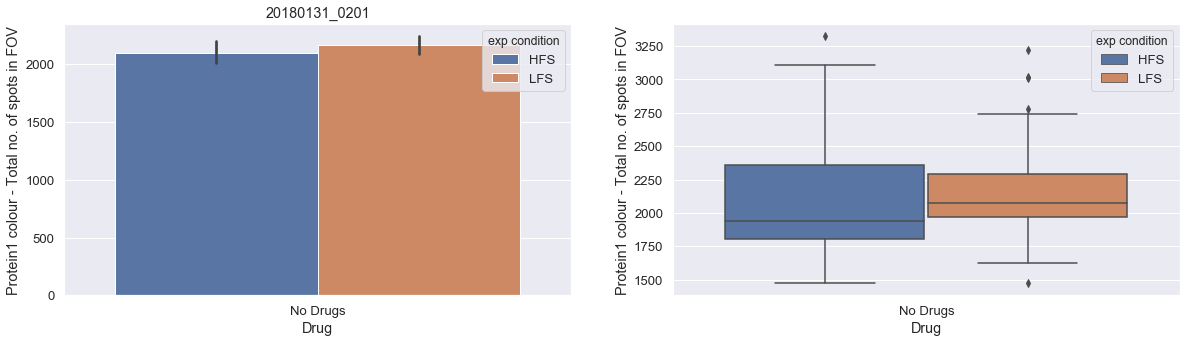

In [236]:
vari='Protein1 colour - Total no. of spots in FOV'
for exp in df3["expname2"].unique():
    print(exp)
    print('number of no drug',str(len(df[(df["expname2"]==exp)&(df["Drug"]=="No Drugs")])))
    print('number of DMSO',str(len(df[(df["expname2"]==exp)&(df["Drug"]=="DMSO")])))    
    fig=plt.figure(figsize=(20,5))
    fig.add_subplot(121)
    d=sns.barplot(x="Drug",y=vari,data=df3[df3["expname2"]==exp],hue="exp condition",hue_order=["HFS","LFS"])
    plt.title(exp)
    fig.add_subplot(122)
    d=sns.boxplot(x="Drug",y=vari,data=df3[df3["expname2"]==exp],hue="exp condition",hue_order=["HFS","LFS"])
    

In [190]:
df3.columns

Index(['Drug', 'Mean colour bias of a pixel (Protein1=-1<x<1=Protein2)',
       'Mean correlation coefficient Protein1/Protein2',
       'Protein1 colour - Mean intensity of spots',
       'Protein1 colour - Mean intensity of spots norm2max',
       'Protein1 colour - Mean intensity, masked by Protein2 spots',
       'Protein1 colour - Mean intensity, outside of Protein2 spots',
       'Protein1 colour - Mean spot area [nm]',
       'Protein1 colour - Raw mean intensity',
       'Protein1 colour - Total no. of spots in FOV',
       'Protein1 colour - spots mask',
       'Protein2 colour - Mean intensity of spots',
       'Protein2 colour - Mean intensity of spots norm2max',
       'Protein2 colour - Mean spot area [nm]',
       'Protein2 colour - Raw mean intensity',
       'Protein2 colour - Total no. of spots in FOV',
       'Protein2 colour - spots mask', 'Slice_id', 'Unnamed: 0',
       'exp condition', 'exp name', 'expname2', 'filename', 'label',
       'MergedDrugs'],
      dtype

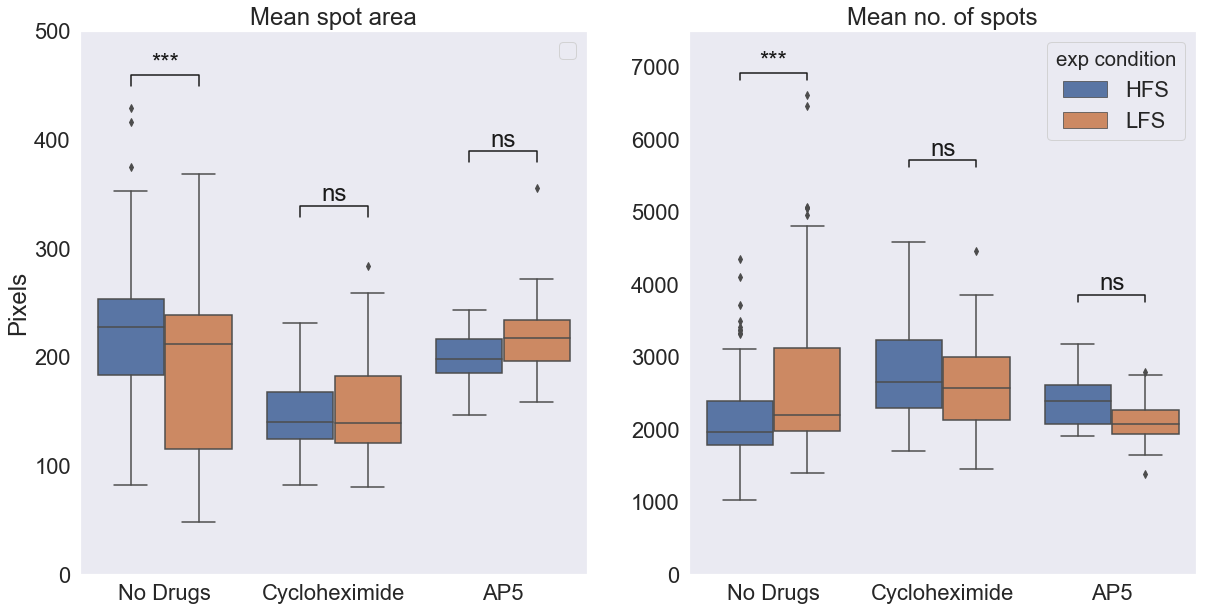

In [281]:
varpl='Protein1 colour - Mean spot area [nm]'
varpl2='Protein1 colour - Total no. of spots in FOV'
df['Protein1 colour - Mean intensity of spots']=df['Protein1 colour - Mean intensity of spots'].astype(float)
sns.set(font_scale=2)
fig=plt.figure(figsize=(20,10))
fig.add_subplot(121)
d=sns.boxplot(x="MergedDrugs",y='Protein1 colour - Mean spot area [nm]',data=df3,hue="exp condition",order=["No Drugs","Cycloheximide","AP5"])
d.set_ylabel('Pixels')
d.legend('')
d.grid(False)
d.set_xlabel('')
plt.title('Mean spot area')
d.set_ylim([0,500])

x1, x2 = 0.8, 1.2 
   # columns 'HFS' and 'LFS'
y, h, col = df3[varpl].max() -100, 10, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)

plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)

x1, x2 = -0.2, 0.2   # columns 'HFS' and 'LFS'
y, h, col = df3[varpl].max()+20 , 10, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)

plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

x1, x2 = 1.8, 2.2   # columns 'HFS' and 'LFS'
y, h, col = df3[varpl].max() -50, 10, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)

plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)

fig.add_subplot(122)
g=sns.boxplot(x="MergedDrugs",y='Protein1 colour - Total no. of spots in FOV',data=df3,hue="exp condition",order=["No Drugs","Cycloheximide","AP5"])
g.set_ylabel('')
plt.title('Mean no. of spots')
g.set_xlabel('')
g.grid(False)
g.set_ylim([0,7500])
x1, x2 = 0.8, 1.2   # columns 'HFS' and 'LFS'
y, h, col = df3[varpl2].max() -1000, 100, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)

plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)

x1, x2 = -0.2, 0.2
  # columns 'HFS' and 'LFS'
y, h, col = df3[varpl2].max()+200 , 100, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)

plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

x1, x2 = 1.8, 2.2   # columns 'HFS' and 'LFS'
y, h, col = df3[varpl2].mean() +1300, 100, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)

plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)

##t tests
Nobic = df3[(df3["MergedDrugs"]=="No Drugs")&(df3["exp condition"]=="HFS")][varpl2]
Bic = df3[(df3["MergedDrugs"]=="No Drugs")&(df3["exp condition"]=="LFS")][varpl2]
[stat,pval]=stats.ttest_ind(Nobic, Bic,nan_policy='omit')
#print(pval)
    

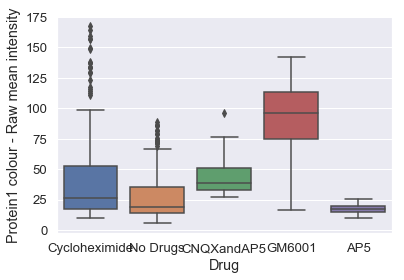

In [141]:
df['Protein1 colour - Raw mean intensity'] = df['Protein1 colour - Raw mean intensity'].astype(float)
sns.boxplot(y='Protein1 colour - Raw mean intensity',x='Drug',data=df)

In [ ]:
sns.set(font_scale=1.3)


fig1=plt.figure()
d=sns.barplot(y ="Protein1 colour - Raw mean intensity", x="Drug",hue="exp condition",data=df,#ci='sd',
                 ) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein1 colour - Raw mean intensity", x="Drug",hue="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Raw mean intensity']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Raw mean intensity']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df['Protein1 colour - Raw mean intensity'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig1.savefig(output+'_'+'plot1.png',bbox_inches='tight')

fig2=plt.figure()
d=sns.barplot(y ='Protein2 colour - Raw mean intensity', x="Drug",hue="exp condition",data=df, #ci='sd',
                 ) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein2 colour - Raw mean intensity", x="Drug",hue="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein2 colour - Raw mean intensity']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein2 colour - Raw mean intensity']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df['Protein2 colour - Raw mean intensity'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig2.savefig(output+'_'+'plot2.png',bbox_inches='tight')

fig3=plt.figure()
d=sns.barplot(y ='Protein1 colour - Mean intensity of spots', x="Drug",hue="exp condition",data=df, #ci='sd',
                 ) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein1 colour - Mean intensity of spots", x="Drug",hue="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Mean intensity of spots']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Mean intensity of spots']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df['Protein1 colour - Mean intensity of spots'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig3.savefig(output+'_'+'plot3.png',bbox_inches='tight')

fig4=plt.figure()
d=sns.barplot(y ='Protein2 colour - Mean intensity of spots', x="Drug",hue="exp condition",data=df, #ci='sd',
                 ) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein2 colour - Mean intensity of spots", x="Drug",hue="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein2 colour - Mean intensity of spots']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein2 colour - Mean intensity of spots']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df['Protein2 colour - Mean intensity of spots'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig4.savefig(output+'_'+'plot4.png',bbox_inches='tight')

fig5=plt.figure()
d=sns.barplot(y ='Protein1 colour - Total no. of spots in FOV', x="Drug",hue="exp condition",data=df, #ci='sd',
                 ) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein1 colour - Total no. of spots in FOV", x="Drug",hue="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Total no. of spots in FOV']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Total no. of spots in FOV']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df['Protein1 colour - Total no. of spots in FOV'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig5.savefig(output+'_'+'plot5.png',bbox_inches='tight')

fig6=plt.figure()
d=sns.barplot(y ='Protein2 colour - Total no. of spots in FOV', x="Drug",hue="exp condition",data=df, #ci='sd',
                 ) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein2 colour - Total no. of spots in FOV", x="Drug",hue="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein2 colour - Total no. of spots in FOV']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein2 colour - Total no. of spots in FOV']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df['Protein2 colour - Total no. of spots in FOV'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig6.savefig(output+'_'+'plot6.png',bbox_inches='tight')

fig7=plt.figure()
d=sns.barplot(y ='Protein1 colour - Mean spot area [nm]', x="Drug",hue="exp condition",data=df, #ci='sd',
                 ) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein1 colour - Mean spot area [nm]", x="Drug",hue="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Mean spot area [nm]']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Mean spot area [nm]']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df['Protein1 colour - Mean spot area [nm]'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig7.savefig(output+'_'+'plot7.png',bbox_inches='tight')

fig8=plt.figure()
d=sns.barplot(y ='Protein2 colour - Mean spot area [nm]', x="Drug",hue="exp condition",data=df, #ci='sd',
                 ) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein2 colour - Mean spot area [nm]", x="Drug",hue="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein2 colour - Mean spot area [nm]']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein2 colour - Mean spot area [nm]']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df['Protein2 colour - Mean spot area [nm]'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig8.savefig(output+'_'+'plot8.png',bbox_inches='tight')

fig9=plt.figure()
d=sns.barplot(y ='Mean correlation coefficient Protein1/Protein2', x="Drug",hue="exp condition",data=df, #ci='sd',
                 ) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Mean correlation coefficient Protein1/Protein2", x="Drug",hue="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Mean correlation coefficient Protein1/Protein2']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Mean correlation coefficient Protein1/Protein2']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df['Mean correlation coefficient Protein1/Protein2'].mean() + 0.2, 0.1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig9.savefig(output+'_'+'plot9.png',bbox_inches='tight')

fig10=plt.figure()
d=sns.barplot(y ='Protein1 colour - Mean intensity, masked by Protein2 spots', x="Drug",hue="exp condition",data=df, #ci='sd',
                 ) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein1 colour - Mean intensity, masked by Protein2 spots", x="Drug",hue="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Mean intensity, masked by Protein2 spots']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Mean intensity, masked by Protein2 spots']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df['Protein1 colour - Mean intensity, masked by Protein2 spots'].mean() + 0.2, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig10.savefig(output+'_'+'plot10.png',bbox_inches='tight')

fig11=plt.figure()
d=sns.barplot(y ='Protein1 colour - Mean intensity, outside of Protein2 spots', x="Drug",hue="exp condition",data=df, #ci='sd',
                 ) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein1 colour - Mean intensity, outside of Protein2 spots", x="Drug",hue="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Mean intensity, outside of Protein2 spots']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Mean intensity, outside of Protein2 spots']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df['Protein1 colour - Mean intensity, outside of Protein2 spots'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig11.savefig(output+'_'+'plot11.png',bbox_inches='tight')







In [ ]:
#statistics with scipy, plots with seaborn
sns.set(font_scale=1.2)

#raw mean intensity Protein1
Protein1rawint_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Raw mean intensity']
Protein1rawint_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Raw mean intensity']
[stat,pval]=stats.ttest_ind(Protein1rawint_LFS, Protein1rawint_HFS)
print(pval)
sns.factorplot(kind='bar', y='Protein1 colour - Raw mean intensity', x ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'LFS' and 'HFS'
y, h, col = df['Protein1 colour - Raw mean intensity'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#raw mean intensity Protein2
Protein2rawint_LFS = df[df['exp condition'] == 'LFS']['Protein2 colour - Raw mean intensity']
Protein2rawint_HFS = df[df['exp condition'] == 'HFS']['Protein2 colour - Raw mean intensity']
[stat,pval]=stats.ttest_ind(Protein2rawint_LFS, Protein2rawint_HFS)
print(pval)
sns.factorplot(kind='bar', y='Protein2 colour - Raw mean intensity', x ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'LFS' and 'HFS'
y, h, col = df['Protein2 colour - Raw mean intensity'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#raw mean intensity Protein1 spots
Protein1spotint_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Mean intensity of spots']
Protein1spotint_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Mean intensity of spots']
[stat,pval]=stats.ttest_ind(Protein1spotint_LFS, Protein1spotint_HFS)
print(pval)
sns.factorplot(kind='bar', y='Protein1 colour - Mean intensity of spots', x ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'LFS' and 'HFS'
y, h, col = df['Protein1 colour - Mean intensity of spots'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#raw mean intensity Protein2 spots
Protein2spotint_LFS = df[df['exp condition'] == 'LFS']['Protein2 colour - Mean intensity of spots']
Protein2spotint_HFS = df[df['exp condition'] == 'HFS']['Protein2 colour - Mean intensity of spots']
[stat,pval]=stats.ttest_ind(Protein2spotint_LFS, Protein2spotint_HFS)
print(pval)
sns.factorplot(kind='bar', y='Protein2 colour - Mean intensity of spots', x ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'LFS' and 'HFS'
y, h, col = df['Protein2 colour - Mean intensity of spots'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#NO of Protein1 spots in FOV
Protein1spotno_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Total no. of spots in FOV']
Protein1spotno_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Total no. of spots in FOV']
[stat,pval]=stats.ttest_ind(Protein1spotno_LFS, Protein1spotno_HFS)
print(pval)
sns.factorplot(kind='bar', y='Protein1 colour - Total no. of spots in FOV', x ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'LFS' and 'HFS'
y, h, col = df['Protein1 colour - Total no. of spots in FOV'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#NO of Protein2 spots in FOV
Protein2spotno_LFS = df[df['exp condition'] == 'LFS']['Protein2 colour - Total no. of spots in FOV']
Protein2spotno_HFS = df[df['exp condition'] == 'HFS']['Protein2 colour - Total no. of spots in FOV']
[stat,pval]=stats.ttest_ind(Protein2spotno_LFS, Protein2spotno_HFS)
print(pval)
sns.factorplot(kind='bar', y='Protein2 colour - Total no. of spots in FOV', x ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'LFS' and 'HFS'
y, h, col = df['Protein2 colour - Total no. of spots in FOV'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#Spot Area of Protein1 
Protein1spotarea_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Mean spot area [nm]']
Protein1spotarea_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Mean spot area [nm]']
[stat,pval]=stats.ttest_ind(Protein1spotarea_LFS, Protein1spotarea_HFS)
print(pval)
sns.factorplot(kind='bar', y='Protein1 colour - Mean spot area [nm]', x ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'LFS' and 'HFS'
y, h, col = df['Protein1 colour - Mean spot area [nm]'].mean() + 200, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#Protein2 spot area
Protein2spotarea_LFS = df[df['exp condition'] == 'LFS']['Protein2 colour - Mean spot area [nm]']
Protein2spotarea_HFS = df[df['exp condition'] == 'HFS']['Protein2 colour - Mean spot area [nm]']
[stat,pval]=stats.ttest_ind(Protein2spotarea_LFS, Protein2spotarea_HFS)
print(pval)
sns.factorplot(kind='bar', y='Protein2 colour - Mean spot area [nm]', x ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'LFS' and 'HFS'
y, h, col = df['Protein2 colour - Mean spot area [nm]'].mean() + 200, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#Corrcoeff Protein1 Protein2
Corrcoeff_LFS = df[df['exp condition'] == 'LFS']['Mean correlation coefficient Protein1/Protein2']
Corrcoeff_HFS = df[df['exp condition'] == 'HFS']['Mean correlation coefficient Protein1/Protein2']
[stat,pval]=stats.ttest_ind(Corrcoeff_LFS, Corrcoeff_HFS)
print(pval)
sns.factorplot(kind='bar', y='Mean correlation coefficient Protein1/Protein2', x ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'LFS' and 'HFS'
y, h, col = df['Mean correlation coefficient Protein1/Protein2'].mean()+0.2 , 0.2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#Protein1 intensity, masked by Protein2
Protein1synapsesint_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Mean intensity, masked by Protein2 spots']
Protein1synapsesint_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Mean intensity, masked by Protein2 spots']
[stat,pval]=stats.ttest_ind(Protein1synapsesint_LFS, Protein1synapsesint_HFS)
print(pval)
sns.factorplot(kind='bar', y='Protein1 colour - Mean intensity, masked by Protein2 spots', x ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'LFS' and 'HFS'
y, h, col = df['Protein1 colour - Mean intensity, masked by Protein2 spots'].mean() + 12, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#Protein1 intensity, not masked by Protein2
Protein1notsynapsesint_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Mean intensity, outside of Protein2 spots']
Protein1notsynapsesint_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Mean intensity, outside of Protein2 spots']
[stat,pval]=stats.ttest_ind(Protein1notsynapsesint_LFS, Protein1notsynapsesint_HFS)
print(pval)
sns.factorplot(kind='bar', y='Protein1 colour - Mean intensity, outside of Protein2 spots', x ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'LFS' and 'HFS'
y, h, col = df['Protein1 colour - Mean intensity, outside of Protein2 spots'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()


In [ ]:
sns.set(font_scale=1.5)

fig12=plt.figure(figsize=(10,10))
d=sns.boxplot(y ='Protein1 colour - Raw mean intensity', x='Slice_id',data=df,hue='exp condition')
d.set_xticklabels('')
plt.show()
fig12.savefig(output+'_'+'plot_individual_slices.png',bbox_inches='tight')



In [ ]:
df.Drug


## Calculate enrichment value (of HFS over LFS)

In [ ]:
# make new dataframe for collecting results from all exps
HFSoverLFS_many_exps = {"Exp Date":[],
                        "Treatment":[],
                        "Ratio HFS/LFS Protein 1":[],
                       "Ratio HFS/LFS Protein 2":[]}
Experiments_summary_of_HFS_LFS_comp=pd.DataFrame(HFSoverLFS_many_exps)

In [24]:
Experiments_summary_of_HFS_LFS_comp=pd.DataFrame.from_csv('/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/LTPanalysis/Experiments_summary_of_HFS_LFS_comp.csv')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [25]:
Experiments_summary_of_HFS_LFS_comp

,Exp Date,Ratio HFS/LFS Protein 1,Ratio HFS/LFS Protein 2,Treatment
0,20180131and0201,1.181765,0.970817,No Drugs
0,20180316_LTPStim_Cy3laserto20percent,0.923984,1.101175,35uM_cyclo
0,20180316_LTPStim_Cy3laserto20percent,0.897371,0.978643,70uM_cyclo
0,20180305_LTPStim_BetweenFrames_notdoneimaging,0.793943,0.949581,1_hr_incubation
0,20180305_LTPStim_BetweenFrames_notdoneimaging,1.043736,1.107796,CNQXandAP5
0,20180214and0215_LTPStim_betweenframes_newlaser,0.839187,0.782101,AP5
0,20180214and0215_LTPStim_betweenframes_newlaser,0.979267,0.872826,No Drugs
0,20180411and0412_LTPStim_Cy3laserto25percent,NaN,NaN,No Drugs
0,20180411and0412_LTPStim_Cy3laserto25percent,1.670227,1.335140,DMSO
0,20180411and0412_LTPStim_Cy3laserto25percent,1.520191,1.058885,GM6001


In [26]:
#specify details of current experiment and add to df
expdate='20180528_LTPStim'
treatment='CNQXandAP5' #No Drugs, AP5, etc, 1_hr_incubation, CNQXandAP5

hfs=df['exp condition']=="HFS"
lfs=df['exp condition']=="LFS"

drug=df['Drug']=='CNQXandAP5' #change here according to all drug conditions

a=df[hfs & drug]
b=df[lfs & drug]

prot1=a['Protein1 colour - Raw mean intensity'].mean()/b['Protein1 colour - Raw mean intensity'].mean()
prot2=a['Protein2 colour - Raw mean intensity'].mean()/b['Protein2 colour - Raw mean intensity'].mean()


newexp = pd.DataFrame([[expdate, treatment, prot1,prot2]],columns=['Exp Date', 'Treatment', 'Ratio HFS/LFS Protein 1', 'Ratio HFS/LFS Protein 2'])

Experiments_summary_of_HFS_LFS_comp=Experiments_summary_of_HFS_LFS_comp.append(newexp)

Experiments_summary_of_HFS_LFS_comp

,Exp Date,Ratio HFS/LFS Protein 1,Ratio HFS/LFS Protein 2,Treatment
0,20180131and0201,1.181765,0.970817,No Drugs
0,20180316_LTPStim_Cy3laserto20percent,0.923984,1.101175,35uM_cyclo
0,20180316_LTPStim_Cy3laserto20percent,0.897371,0.978643,70uM_cyclo
0,20180305_LTPStim_BetweenFrames_notdoneimaging,0.793943,0.949581,1_hr_incubation
0,20180305_LTPStim_BetweenFrames_notdoneimaging,1.043736,1.107796,CNQXandAP5
0,20180214and0215_LTPStim_betweenframes_newlaser,0.839187,0.782101,AP5
0,20180214and0215_LTPStim_betweenframes_newlaser,0.979267,0.872826,No Drugs
0,20180411and0412_LTPStim_Cy3laserto25percent,NaN,NaN,No Drugs
0,20180411and0412_LTPStim_Cy3laserto25percent,1.670227,1.335140,DMSO
0,20180411and0412_LTPStim_Cy3laserto25percent,1.520191,1.058885,GM6001


In [27]:
Experiments_summary_of_HFS_LFS_comp.to_csv('/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/LTPanalysis/Experiments_summary_of_HFS_LFS_comp.csv')

In [ ]:
Experiments_summary_of_HFS_LFS_comp

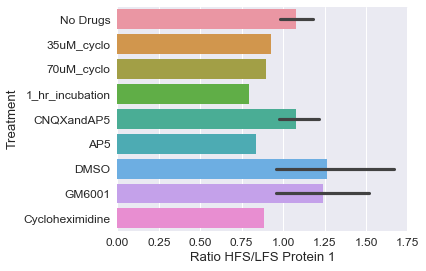

In [28]:
sns.factorplot(kind='bar', x='Ratio HFS/LFS Protein 1', y ='Treatment',data=Experiments_summary_of_HFS_LFS_comp, size=4, aspect=1.5) 

